In [1]:
import pandas as pd
import json
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data from a file
with open('/Users/bishalthapa/Desktop/2024/Deep Learning/Project/clinc150_uci/data_full.json', 'r') as file:
    data = json.load(file)
    # print(data)

In [3]:
# Convert lists to DataFrames
train_df = pd.DataFrame(data['train'], columns=['text', 'intent'])
val_df = pd.DataFrame(data['val'], columns=['text', 'intent'])
test_df = pd.DataFrame(data['test'], columns=['text', 'intent'])
oos_train_df=pd.DataFrame(data['oos_train'],columns=['text','intent'])
oos_test_df=pd.DataFrame(data['oos_test'],columns=['text','intent'])
oos_val_df=pd.DataFrame(data['oos_val'],columns=['text','intent'])

In [4]:
#oos_test_df

In [5]:
# Prepare the tokenizer for LSTM
lstm_tokenizer = Tokenizer(num_words=10000)  
lstm_tokenizer.fit_on_texts(train_df['text']) 

In [6]:
# Preprocess the data for LSTM
max_length = 100  
train_sequences = lstm_tokenizer.texts_to_sequences(train_df['text'])
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_length)

In [7]:
#train_sequences_padded

In [8]:
val_sequences = lstm_tokenizer.texts_to_sequences(val_df['text'])
val_sequences_padded = pad_sequences(val_sequences, maxlen=max_length)

In [9]:
test_sequences = lstm_tokenizer.texts_to_sequences(test_df['text'])
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_length)

In [10]:
# Creating a set of all possible labels including in-domain and 'oos'
all_labels = set(train_df['intent']).union(set(val_df['intent']), set(test_df['intent']), ['oos'])

# Creating a label index mapping every label to an integer
label_index = {label: idx for idx, label in enumerate(all_labels)}

In [11]:
#label_index

In [12]:
def encode_labels(labels, label_index):
    # Map labels to their respective index
    label_indices = [label_index[label] for label in labels]
    # Encode labels as one-hot vectors
    return to_categorical(label_indices, num_classes=len(label_index))

# Encoding labels for all datasets
train_labels = encode_labels(train_df['intent'], label_index)
val_labels = encode_labels(val_df['intent'], label_index)
test_labels = encode_labels(test_df['intent'], label_index)
oos_train_labels = encode_labels(['oos'] * len(oos_train_df), label_index)
oos_val_labels = encode_labels(['oos'] * len(oos_val_df), label_index)
oos_test_labels = encode_labels(['oos'] * len(oos_test_df), label_index)

In [13]:
# Build and compile the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))
lstm_model.add(LSTM(units=64))
lstm_model.add(Dense(len(label_index), activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
# Train the LSTM model
lstm_model.fit(train_sequences_padded, train_labels, batch_size=128, epochs=10, validation_data=(val_sequences_padded, val_labels))


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.0327 - loss: 4.9116 - val_accuracy: 0.2730 - val_loss: 3.8469
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.4842 - loss: 3.1712 - val_accuracy: 0.7247 - val_loss: 2.0092
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.8383 - loss: 1.4875 - val_accuracy: 0.8160 - val_loss: 1.2333
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.9257 - loss: 0.7668 - val_accuracy: 0.8460 - val_loss: 0.8892
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.9550 - loss: 0.4641 - val_accuracy: 0.8583 - val_loss: 0.7303
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9706 - loss: 0.3096 - val_accuracy: 0.8653 - val_loss: 0.6387
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9776 - loss: 0.2185 - val_accuracy: 0.8763 - val_loss: 0.6002
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9853 - loss: 0.1622 - val

In [15]:
# Additional preprocessing for the out-of-sample data
oos_train_sequences = lstm_tokenizer.texts_to_sequences(oos_train_df['text'])
oos_train_sequences_padded = pad_sequences(oos_train_sequences, maxlen=max_length)

oos_val_sequences = lstm_tokenizer.texts_to_sequences(oos_val_df['text'])
oos_val_sequences_padded = pad_sequences(oos_val_sequences, maxlen=max_length)

oos_test_sequences = lstm_tokenizer.texts_to_sequences(oos_test_df['text'])
oos_test_sequences_padded = pad_sequences(oos_test_sequences, maxlen=max_length)

In [16]:
#oos_test_sequences_padded

In [17]:
# Create an additional 'oos' or 'unknown' label for out-of-sample data
oos_label = 'oos'
if oos_label not in label_index:
    label_index[oos_label] = len(label_index)

In [18]:
# Combine in-domain and out-of-sample training data
combined_train_sequences_padded = np.concatenate([train_sequences_padded, oos_train_sequences_padded])
combined_train_labels = np.concatenate([train_labels, oos_train_labels])

In [19]:
combined_val_sequences_padded = np.concatenate([val_sequences_padded, oos_val_sequences_padded])
combined_val_labels = np.concatenate([val_labels, oos_val_labels])
lstm_model.evaluate(combined_val_sequences_padded, combined_val_labels)

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8877 - loss: 0.5154


[0.8519336581230164, 0.8538709878921509]

In [20]:
combined_test_sequences_padded = np.concatenate([test_sequences_padded, oos_test_sequences_padded])
combined_test_labels = np.concatenate([test_labels, oos_test_labels])
lstm_model.evaluate(combined_val_sequences_padded, combined_val_labels)

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8877 - loss: 0.5154


[0.8519336581230164, 0.8538709878921509]

In [32]:
# Train the model
lstm_model.fit(combined_train_sequences_padded, combined_train_labels, batch_size=128, epochs=100, validation_data=(combined_val_sequences_padded, combined_val_labels))

# Evaluate on the test set
lstm_model.evaluate(combined_test_sequences_padded, combined_test_labels)

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 1.0000 - loss: 2.3938e-04 - val_accuracy: 0.8668 - val_loss: 0.7064
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 1.0000 - loss: 2.1786e-04 - val_accuracy: 0.8661 - val_loss: 0.7134
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 1.0000 - loss: 2.1778e-04 - val_accuracy: 0.8684 - val_loss: 0.7181
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 1.0000 - loss: 1.8968e-04 - val_accuracy: 0.8655 - val_loss: 0.7214
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 1.0000 - loss: 1.9693e-04 - val_accuracy: 0.8690 - val_loss: 0.7197
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 1.0000 - loss: 1.8185e-04 - val_accuracy: 0.8674 - val_loss: 0.7231
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 1.0000 - loss: 1.6279e-04 - val_accuracy: 0.8655 - val_loss: 0.7302
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step 

[1.7324877977371216, 0.7699999809265137]

172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Classification Report:
                            precision    recall  f1-score   support

                  routing       1.00      1.00      1.00        30
               play_music       0.73      0.63      0.68        30
       cancel_reservation       0.68      1.00      0.81        30
                 calories       0.91      0.97      0.94        30
            rollover_401k       0.97      0.97      0.97        30
                     time       0.74      0.93      0.82        30
         schedule_meeting       0.94      0.97      0.95        30
          meaning_of_life       0.82      0.93      0.87        30
                roll_dice       0.94      0.97      0.95        30
                next_song       0.91      1.00      0.95        30
            interest_rate       0.85      0.93      0.89        30
                   repeat       0.85      0.93      0.89        30
                    alarm       0.88      0.97      0.92      

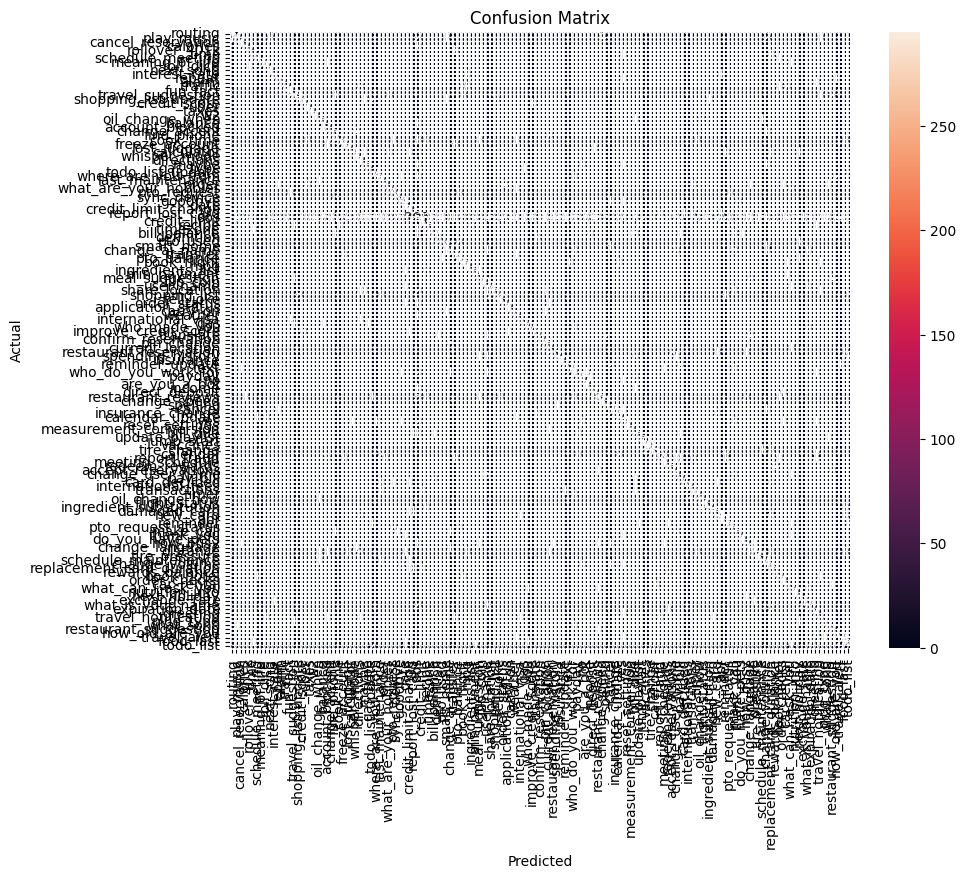

In [23]:
# Predict classes with LSTM model on the validation set
test_predictions = lstm_model.predict(combined_test_sequences_padded)
test_predictions_classes = np.argmax(test_predictions, axis=1)
true_test_classes = np.argmax(combined_test_labels, axis=1)

# Create the confusion matrix
cm = confusion_matrix(true_test_classes, test_predictions_classes)

# Generate a classification report
report = classification_report(true_test_classes, test_predictions_classes, target_names=list(label_index.keys()))

print("Classification Report:\n", report)

# Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(label_index.keys()), yticklabels=list(label_index.keys()))
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
## ROC AUC FOR FEW CLASSES

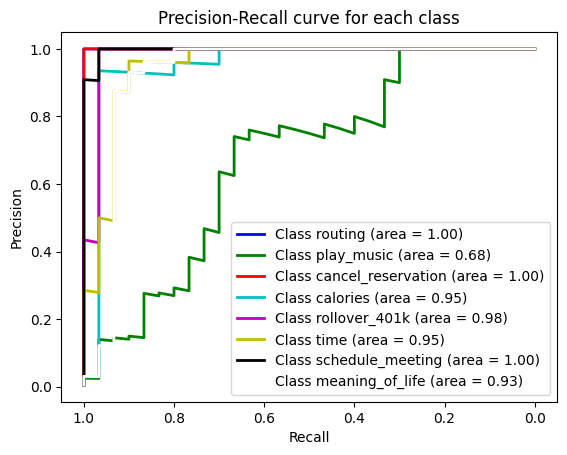

In [25]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize


# For precision-recall curve, you need binarized labels
binarized_test_labels = label_binarize(true_test_classes, classes=range(len(label_index)))

# Calculate precision and recall
precision = dict()
recall = dict()
for i in range(len(label_index)):
    precision[i], recall[i], _ = precision_recall_curve(binarized_test_labels[:, i],
                                                        test_predictions[:, i])

# Plot the precision-recall curve for each class
for i, color in zip(range(len(label_index)), "bgrcmykw"):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Class {0} (area = {1:0.2f})'.format(list(label_index.keys())[i], auc(recall[i], precision[i])))

plt.gca().invert_xaxis()  # Inverts the x-axis
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Generate predictions for combined validation dataset 
# combined_val_predictions = lstm_model.predict(combined_val_sequences_padded)
# combined_val_predictions_classes = np.argmax(combined_val_predictions, axis=1)  # Get the index of the max logit

In [ ]:
## CHANGING ALL IN_DOMAIN CLASSES AS 0 AND OUT-OF-DOMAIN AS 1 FOR SIMPLER CONFUSION MATRIX

In [30]:
# Convert multi-class labels to binary labels (0 for in-domain, 1 for out-of-domain)
def convert_to_binary(classes, oos_index):
    return [0 if class_index != oos_index else 1 for class_index in classes]

# Assuming `oos_index` is the index of 'oos' in label_index
oos_index = label_index['oos']

# Convert true labels for validation
binary_true_test_labels = convert_to_binary(np.argmax(combined_test_labels, axis=1), oos_index)

# Assuming you've made predictions with the model
test_predictions = lstm_model.predict(combined_test_sequences_padded)
binary_predicted_test_labels = convert_to_binary(np.argmax(test_predictions, axis=1), oos_index)


172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


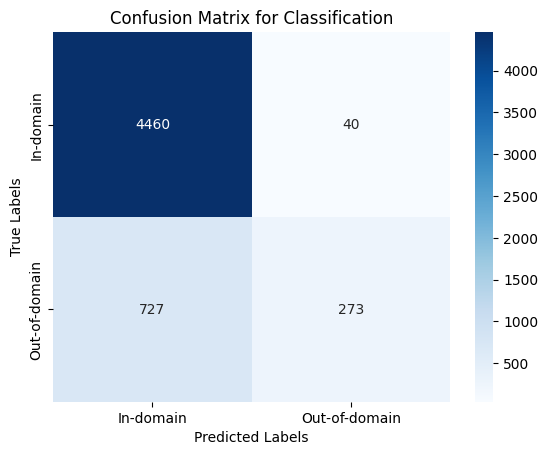

               precision    recall  f1-score   support

    In-domain       0.86      0.99      0.92      4500
Out-of-domain       0.87      0.27      0.42      1000

     accuracy                           0.86      5500
    macro avg       0.87      0.63      0.67      5500
 weighted avg       0.86      0.86      0.83      5500



In [31]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(binary_true_test_labels, binary_predicted_test_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['In-domain', 'Out-of-domain'], yticklabels=['In-domain', 'Out-of-domain'])
plt.title('Confusion Matrix for Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report for precision, recall, F1-score
report = classification_report(binary_true_test_labels, binary_predicted_test_labels, target_names=['In-domain', 'Out-of-domain'])
print(report)


In [ ]:
fpr, tpr, thresholds = roc_curve(binary_true_val_labels, val_predictions[:, oos_index])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
